In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import keras_tuner as kt
from skimage.transform import resize
from matplotlib import pyplot as plt
from skimage.io import imshow

In [2]:
np.random.seed=42

In [3]:
WIDTH = 256
HEIGHT = 256
CHANNELS = 3

In [4]:
# C:\Users\mogal\Data\RAW\Training\RAW
path, dirs, trainingfiles = next(os.walk('Data/RAW/Training/RAW/'))
path, dirs, validationfiles = next(os.walk('Data/RAW/Testing/RAW/'))
path, dirs, Testingfiles = next(os.walk('Data/RAW/Testing/RAW/'))

In [5]:
#Resizing Training set Images and Masks
X_train = np.zeros((len(trainingfiles), HEIGHT, WIDTH, CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(trainingfiles), HEIGHT, WIDTH, 1), dtype=np.bool)

raw_data_folder='Data/RAW/Training/RAW'
mask_data_folder='Data/Masking Image/Training/Masking Image'

mask = np.zeros((HEIGHT, WIDTH, 1), dtype=np.bool)
i=0
for filename in os.listdir(raw_data_folder):
    img = cv2.imread(os.path.join(raw_data_folder,filename))
    img=resize(img,(HEIGHT,WIDTH),mode='constant',preserve_range=True)
    X_train[i]=img
    i=i+1
j=0
for filename in os.listdir(mask_data_folder):
    img = cv2.imread(os.path.join(mask_data_folder,filename))
    img= resize(img,(HEIGHT, WIDTH,1),mode='constant',preserve_range=True)
    Y_train[j]=img
    j=j+1

In [6]:
#Resizing Validation set Images and masks
X_valid = np.zeros((len(Testingfiles), HEIGHT, WIDTH, CHANNELS), dtype=np.uint8)
Y_valid = np.zeros((len(Testingfiles), HEIGHT, WIDTH, 1), dtype=np.bool)

raw_data_folder='Data/RAW/Testing/RAW'
mask_data_folder='Data/Masking Image/Testing/Masking Image'

mask = np.zeros((HEIGHT, WIDTH, 1), dtype=np.bool)
i=0
for filename in os.listdir(raw_data_folder):
    img = cv2.imread(os.path.join(raw_data_folder,filename))
    img=resize(img,(HEIGHT,WIDTH),mode='constant',preserve_range=True)
    X_valid[i]=img
    i=i+1
j=0
for filename in os.listdir(mask_data_folder):
    img = cv2.imread(os.path.join(mask_data_folder,filename))
    img= resize(img,(HEIGHT,WIDTH,1),mode='constant',preserve_range=True)
    Y_valid[j]=img
    j=j+1

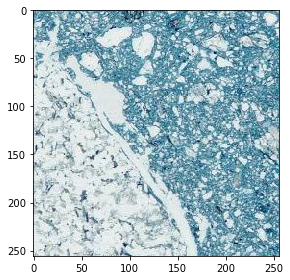

In [53]:
imshow(np.squeeze(X_train[33]))
plt.show()

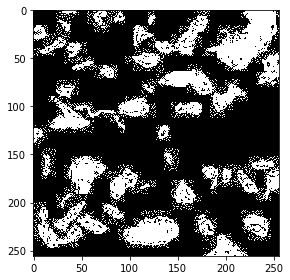

In [54]:
imshow(np.squeeze(Y_train[33]))
plt.show()

In [9]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_thin_section_glacial.h5',verbose=1,save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [10]:
# Unet model architecture implementation was referred from https://github.com/bnsreenu/python_for_microscopists
def model_builder(hp):
    inputs = tf.keras.layers.Input((HEIGHT, WIDTH, CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.5)(c1)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.5)(c2)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.5)(c3)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.5)(c4)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.5)(c5)
    c5 = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.5)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.5)(c7)
    c7 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.5)(c8)
    c8 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.5)(c9)
    c9 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_normal', padding='same')(c9)
    hp_activationfunction_output=hp.Choice('output layer activation function',values=['sigmoid','linear'])

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation=hp_activationfunction_output)(c9)

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4,1e-5])

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [11]:
tuner = kt.RandomSearch(model_builder,
                        objective = 'val_accuracy', 
                        max_trials = 2,
                       directory='newmydocuments1')


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
output layer activation function (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [13]:
tuner.search(x=X_train,y=Y_train, epochs=50, validation_data=(X_valid,Y_valid),callbacks=callbacks)

Trial 2 Complete [00h 08m 20s]
val_accuracy: 0.7019237875938416

Best val_accuracy So Far: 0.7019237875938416
Total elapsed time: 01h 47m 50s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_model = tuner.get_best_models(1)[0]

In [15]:
train_output_prob = best_model.predict(X_train, verbose=1)
test_output_prob = best_model.predict(X_valid, verbose=1)

2/2 [==============================] - 1s 475ms/step


In [17]:
train_output = (train_output_prob > 0.5).astype(np.uint8)
test_output = (test_output_prob > 0.5).astype(np.uint8)

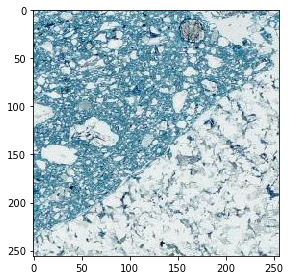

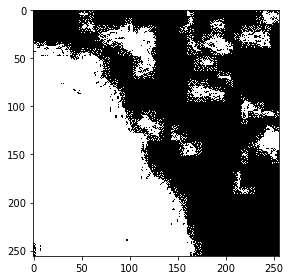

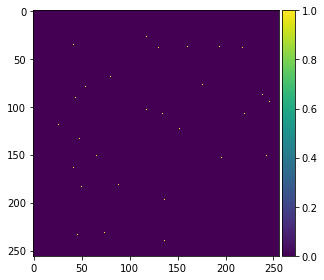

In [51]:
imshow(X_train[32])
plt.show()
imshow(np.squeeze(Y_train[32]))
plt.show()
imshow(np.squeeze(train_output[32]))
plt.show()

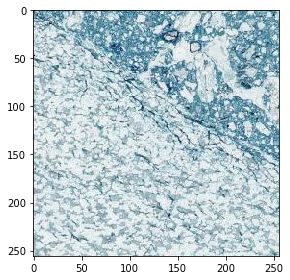

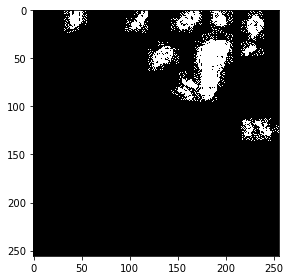

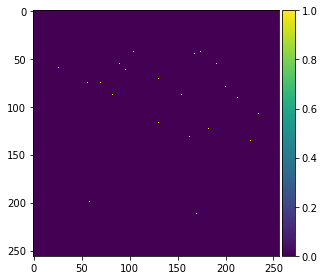

In [58]:
# predication
imshow(X_valid[10])
plt.show()
imshow(np.squeeze(Y_valid[10]))
plt.show()
imshow(np.squeeze(test_output[10]))
plt.show()

In [52]:
import numpy
intersection = numpy.logical_and(X_valid, Y_valid)
union = numpy.logical_or(X_valid, Y_valid)
Jss = numpy.sum(intersection) / numpy.sum(union)
print("Jacard Similarity score",round(Jss*100,2)," %")

Jacard Similarity score 29.8  %
